In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv("Customer Churn.csv")

In [3]:
df = df.drop(columns=['Age'])

In [4]:
label_encoders = {}
for col in ['Tariff Plan', 'Status', 'Age Group']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [5]:
X = df.drop(columns=['Churn'])
y = df['Churn']

In [6]:
X.fillna(X.median(), inplace=True)
y.fillna(y.median(), inplace=True)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [10]:
# Variational Autoencoder (VAE) for Synthetic Data Generation
def build_vae(input_dim):
    encoding_dim = 8
    inputs = Input(shape=(input_dim,))
    x = Dense(16, activation='relu')(inputs)
    x = Dense(encoding_dim, activation='relu')(x)
    x = Dense(16, activation='relu')(x)
    outputs = Dense(input_dim, activation='linear')(x)
    
    vae = Model(inputs, outputs)
    vae.compile(optimizer='adam', loss='mse')
    return vae

vae = build_vae(X_train.shape[1])
vae.fit(X_train, X_train, epochs=50, batch_size=16, verbose=0)
X_synthetic = vae.predict(X_train)

134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [11]:
# ANN Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)), #X_train.shape[1],
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

C:\Users\maliv\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test), verbose=0)

In [14]:
# Model Evaluation
y_pred = (model.predict(X_test) > 0.5).astype("int32")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.92      0.95       520
           1       0.72      0.95      0.82       110

    accuracy                           0.93       630
   macro avg       0.85      0.93      0.88       630
weighted avg       0.94      0.93      0.93       630

Accuracy Score: 0.9253968253968254


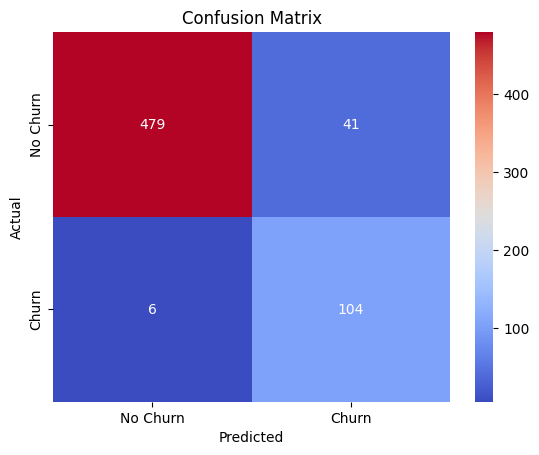

In [15]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


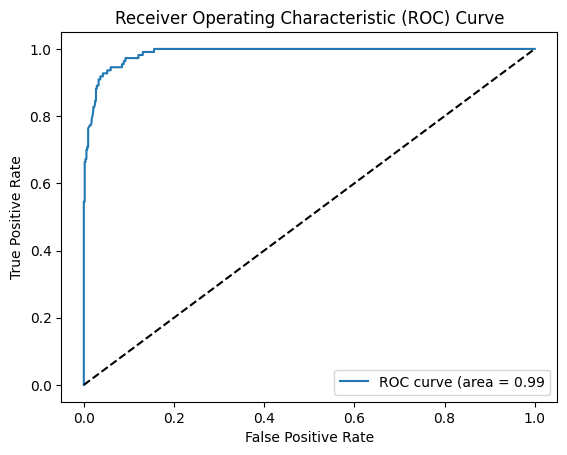

In [16]:
y_prob = model.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

In [17]:
model.save("churn_model.h5")

In [18]:
model.save("churn_model.keras")

In [19]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Load Data
df = pd.read_csv("Customer Churn.csv")
df = df.drop(columns=['Age'])  # Ensure this column was removed in training

# Label Encoding
label_encoders = {}
for col in ['Tariff Plan', 'Status', 'Age Group']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Prepare Feature Set
X = df.drop(columns=['Churn'])
y = df['Churn']

# Load the Scaler and Model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # Fit the scaler on training data
# model = load_model("churn_model.h5")  # Load the trained model
model = load_model("churn_model.keras")  # Load the trained model

# **New Customer Data (Ensure it Matches X.columns)**
new_customer = {
    "Call  Failure": 5,
    "Complains": 0,
    "Subscription  Length": 12,
    "Charge  Amount": 50.0,
    "Seconds of Use": 2000,
    "Frequency of use": 15,
    "Customer Value": 500,
    "Tariff Plan": "Standard",
    "Status": "Active",
    "Age Group": "Adult",
    "Frequency of SMS": 20,
    "Distinct Called Numbers": 30
}

# Convert to DataFrame
new_customer_df = pd.DataFrame([new_customer])

# Handle Missing Columns
missing_cols = set(X.columns) - set(new_customer_df.columns)
for col in missing_cols:
    new_customer_df[col] = 0  # Assign default value (modify if necessary)

# Handle Categorical Encoding
for col in ['Tariff Plan', 'Status', 'Age Group']:
    if new_customer_df[col][0] in label_encoders[col].classes_:
        new_customer_df[col] = label_encoders[col].transform([new_customer_df[col][0]])
    else:
        new_customer_df[col] = -1  # Assign unknown category

# Ensure Column Order Matches Training Data
new_customer_df = new_customer_df[X.columns]

# Apply Scaling
new_customer_scaled = scaler.transform(new_customer_df)

# Predict Churn Probability
churn_probability = model.predict(new_customer_scaled)[0][0]

# Convert to Binary Class
churn_prediction = "Churn" if churn_probability > 0.5 else "No Churn"

# Output Result
print(f"Churn Probability: {churn_probability:.2f}")
print(f"Predicted Class: {churn_prediction}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step

C:\Users\maliv\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
Churn Probability: 0.00
Predicted Class: No Churn


In [20]:
import joblib

# Save scaler, label encoders, and feature column order
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(X.columns.tolist(), "X_columns.pkl")


['X_columns.pkl']

In [21]:
# TEST SCRIPT (outside Streamlit)

import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import joblib

model = load_model("churn_model.keras")
scaler = joblib.load("scaler.pkl")
label_encoders = joblib.load("label_encoders.pkl")

# Create a high-risk customer
data = {
    "Call  Failure": 10,
    "Complains": 1,
    "Subscription  Length": 1,
    "Charge  Amount": 10.0,
    "Seconds of Use": np.log1p(100),  # log transformed
    "Frequency of use": 1,
    "Frequency of SMS": 0,
    "Tariff Plan": "Premium",
    "Status": "Married",
    "Age Group": "50+",
    "Customer Value": 0,
    "Distinct Called Numbers": 1
}
df = pd.DataFrame([data])

# Encode categoricals
for col in ["Tariff Plan", "Status", "Age Group"]:
    if data[col] in label_encoders[col].classes_:
        df[col] = label_encoders[col].transform([data[col]])
    else:
        df[col] = -1

# Match column order
df = df[scaler.feature_names_in_]

# Scale
X = scaler.transform(df)

# Predict
pred = model.predict(X)[0][0]
print(f"Predicted churn probability: {pred:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted churn probability: 1.0000


C:\Users\maliv\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
